# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date:  2023**

# Notebook 2b. Labelled Model Training

## 2.0 Imports

In [216]:
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing and NLP Libraries
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [217]:
df = pd.read_csv('../data/annotation file 3600 done 1142022.csv')

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   link_id    5001 non-null   object
 1   parent_id  5001 non-null   object
 2   User       5001 non-null   object
 3   Text       5001 non-null   object
 4   Intent     5001 non-null   object
 5   Support    5001 non-null   object
dtypes: object(6)
memory usage: 235.4+ KB


In [219]:
df.describe()

,link_id,parent_id,User,Text,Intent,Support
count,5001,5001,5001,5001,5001,5001
unique,1948,3153,4662,4952,6,4
top,t3_ladzdt,t3_ladzdt,AutoModerator,GME,u,y
freq,66,46,14,22,3246,2473


In [220]:
df['link_id'].nunique() == df.shape[0]

False

In [221]:
df.isna().sum()/df.shape[0]

link_id      0.003785
parent_id    0.003785
User         0.003785
Text         0.003785
Intent       0.003785
Support      0.003785
dtype: float64

In [222]:
df[ df['Text'].isna() ]

,link_id,parent_id,User,Text,Intent,Support
5001,NaN,NaN,NaN,NaN,NaN,NaN
5002,NaN,NaN,NaN,NaN,NaN,NaN
5003,NaN,NaN,NaN,NaN,NaN,NaN
5004,NaN,NaN,NaN,NaN,NaN,NaN
5005,NaN,NaN,NaN,NaN,NaN,NaN
5006,NaN,NaN,NaN,NaN,NaN,NaN
5007,NaN,NaN,NaN,NaN,NaN,NaN
5008,NaN,NaN,NaN,NaN,NaN,NaN
5009,NaN,NaN,NaN,NaN,NaN,NaN
5010,NaN,NaN,NaN,NaN,NaN,NaN


In [223]:
# Dropping rows that have NaN values
df = df.dropna()

In [224]:
df[ df['Text'].isna() ]

,link_id,parent_id,User,Text,Intent,Support


## 2.1. Cleaning the text (pre-processing)

I am going to exclude information and unclear from the dataset. negative will be assugned rating 0, and positive will be assigned trating 1.  

In [225]:
# df['Intent'] = np.where((df['Intent'] == 'y')  | (df['Intent'] == 'm'), 1, 0)
df['Intent'] = np.where((df['Intent'] == 'y'), 1, 0)
df['Support'] = np.where((df['Support'] == 'y') | (df['Intent'] == 'm'), 1, 0)
df.head()

,link_id,parent_id,User,Text,Intent,Support
0,t3_l71j1l,t1_gl43z92,chasetate27,GME &amp; BB are not on cashapp but AMC &amp; ...,0,0
1,t3_ki3745,t3_ki3745,pmd5700,"Oh GME, you tease!",0,0
2,t3_la75n9,t3_la75n9,PigLizzard,"Dump gme, amc, nok, and bb so we can all buy s...",0,0
3,t3_lw6hoh,t1_gpfpvtf,anono87,Not a single decent DD posted? 9 billion in re...,0,0
4,t3_l9xqem,t3_l9xqem,gluino,Just got into $GME @ 220.,1,0


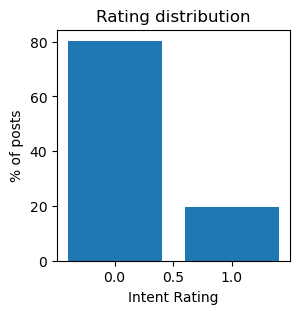

Class imbalance: [0.8 0.2]


In [226]:
values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Intent Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()


print(f"Class imbalance: {np.round(normalized_counts, 2)}")

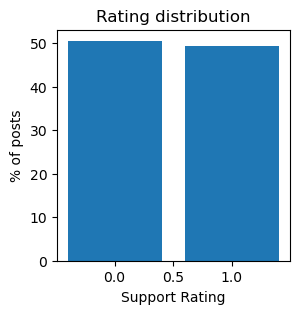

Class imbalance: [0.51 0.49]


In [227]:
values, counts = np.unique(df['Support'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Support Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()
print(f"Class imbalance: {np.round(normalized_counts, 2)}")

### 2.1.1. Custom Tokenization function

To analyse the effect of various text transformation methods and narrow down the feature words I applied stemmation and lemmitisation to both the positive and negative reviews. I read Github notebooks on a similar project posted here (https://github.com/awesomeahi95/Hotel_Review_NLP/blob/master/2.Further_EDA_and_Preprocessing.ipynb), and I liked their approach to stemming and lemming, so I implemented it in the code below, by borrowing some bit of the code frmo that book:

In [228]:
stemmer = PorterStemmer()
lemmy = WordNetLemmatizer()

In [229]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ["you're", 'billion',"that's", "let's", 'gamestop', 'gme' ]

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [230]:
def my_tokenizer(document, lemmatization=True, stemming=True):
    '''
    Function for use in Vectorizer that tokenizes the document
    '''
    # remove punctuation
    for punct in string.punctuation:
        document=document.replace(punct,'')

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word not in stop_words]

    if stemming==False:
        stemmed_tokens_list = []
        for i in tokenized_document:
            token = PorterStemmer().stem(i)
            stemmed_tokens_list.append(token)
        return stemmed_tokens_list

    if lemmatization==True:
        lemmatized_tokens_list = []
        for i in tokenized_document:
            token = WordNetLemmatizer().lemmatize(i)
            lemmatized_tokens_list.append(token)
        return lemmatized_tokens_list

    return tokenized_document

#EXTRA
#to modify the default parameters of my_tokenizer_pattern we can use a lambda function in-place:
#count_vectorizer = CountVectorizer(tokenizer=lambda document: my_tokenizer(document, lemmatization=True, stemming=False))

#what if we only wanted to extract letters, without numeric characters
#consider changing the pattern to pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"

In [231]:
# store simplified data in X and y
X = df['Text']
y = df['Intent']

# splitting our data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

# size of training data
X_train.shape

(4000,)

In [232]:
y.shape

(5001,)

In [233]:
X.shape

(5001,)

## 2.2. Vectorisation 

In [234]:
# Initialise a CountVectorizer object
count_vectorizer = TfidfVectorizer(tokenizer=my_tokenizer,
                                   stop_words=stop_words, # using stop words list that has been customised
                                   min_df=0.005, 
                                   ngram_range=(1,4), 
                                   max_features=1000)

# Preprocess the stop words with the custom tokenizer logic (if applicable)
processed_stop_words = set(my_tokenizer(' '.join(stop_words)))

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(X_train)

# Fit the CountVectorizer object on X_train
X_matrix_train = count_vectorizer.transform(X_train)

print(X_matrix_train.shape);

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'let', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'thats', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  warnings.warn(


(4000, 574)


In [235]:
# sum all the rows for each feature
word_counts = pd.DataFrame(
        {"counts": np.array(X_matrix_train.sum(axis=0)).flatten()},
        index=count_vectorizer.get_feature_names_out()).sort_values("counts", ascending=False)

print('The most common words and their counts are:')
word_counts[:20]

The most common words and their counts are:


,counts
,178.112182
buy,153.318921
amc,129.003233
share,115.358032
stock,102.772390
like,93.548949
game,84.763733
im,78.908132
go,76.279836
short,76.070411


In [236]:
#toarray() method converts sparse matrix to a DataFrame
pd.DataFrame(X_matrix_train.toarray(),columns=count_vectorizer.get_feature_names_out()).head()

,,\n\ni,,1,1 share,10,100,1000,10k,15,...,yes,yesterday,yet,yolo,youre,you’re,🚀,🚀🚀,🚀🚀🚀,🚀🚀🚀🚀
0,0.362456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


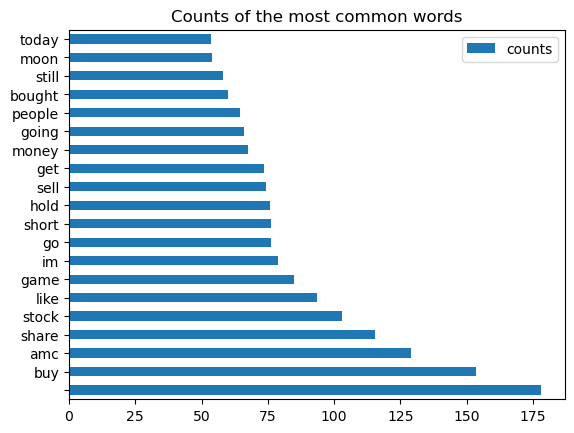

In [237]:
word_counts[:20].plot(kind='barh',title='Counts of the most common words')
plt.show()

Observations:  

* The list of words assocaited with neagtive reviews is quite revealing. 
* Customers clearly dislike unclean small rooms, tired decor, rude staff, poor breakfast selection, expensive hotels where quality does not match the price, broken amenities, noise and poor service.

## 2.3. Logistic Regression

Now that we are happy with the number of features, let's fit a classification model and preprocess the test set

In [238]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1001, 574)

In [239]:
logistic_model=LogisticRegression(C=0.1)
logistic_model.fit(X_matrix_train,y_train)
print(f"Train set accuracy {logistic_model.score(X_matrix_train,y_train):.2f}")
print(f"Test set accuracy {logistic_model.score(X_matrix_test,y_test):.2f}")

Train set accuracy 0.81
Test set accuracy 0.80


* Note, train scores can also be used as one of the metrics to select the optimal min_df & max_df parameters
* Now we can use the model object to access and specifically its **coef_** amd **feature_names_in_** attributes to plot which tokens have the greatest predictive power of negative and postiive reviews
    * Note this approach is only going to work if the model was fitted on a dataframe with the correct feature names, if an array was used, feature names can be extracted from the vectorizer used previously

*---------------------------------------------------------------------*
### Model Analyis

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_76638/1687988034.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_76638/1687988034.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)


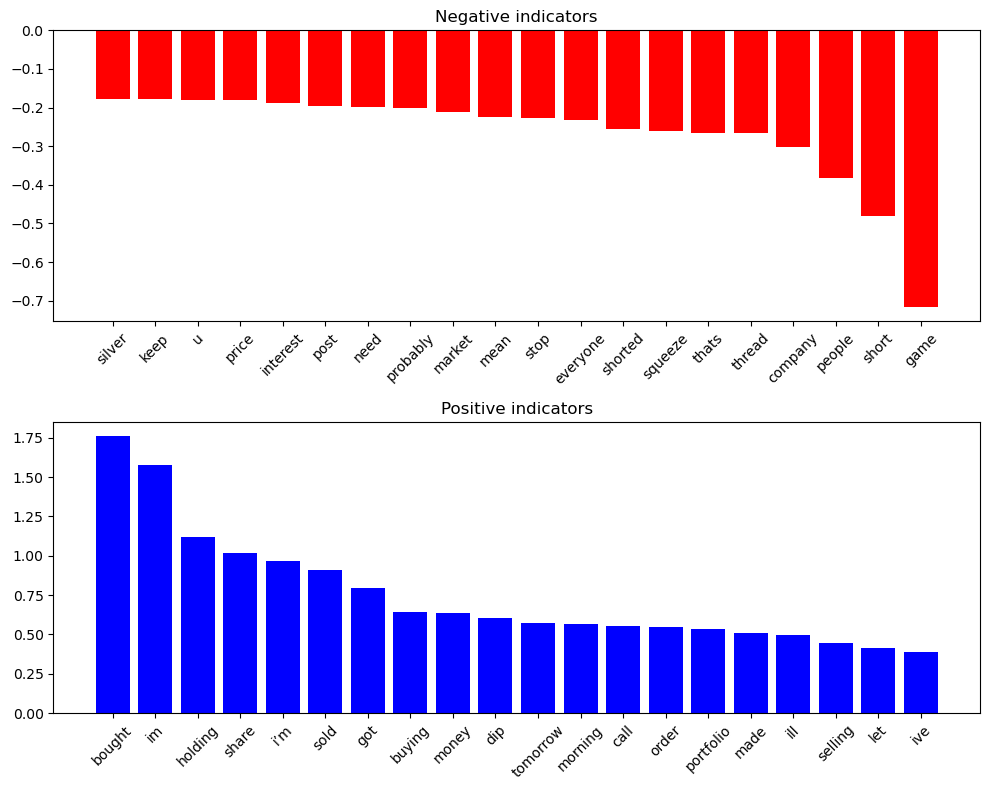

In [240]:
def plot_coefs(model):
    # Create a DataFrame to store the coefficients and corresponding tokens
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "token": count_vectorizer.get_feature_names_out()})
    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot tokens indicating negative sentiment with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens indicating positive sentiment with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

plot_coefs(logistic_model)

Observation:  

The model accuracy on test set is close to the accuracy on the train and valildation sets. This is a good sign, as it inidcates there is no problem with overfitting the model.  We have sufficient number of observations to train the model so that when it is faced with unseen test data it still performs well.   

In [241]:
import joblib

# joblib.dump(log_reg, "../model/posts_removed_textonly_CV.pkl")

## 2.4. Text analysis conclusions

We were asked to perform this analysis in order to determine **what qualities of a hotel stay contribute to greater customer satisfaction and higher ratings.**
Based on the analysis of the text in the positive and negative reviews columns we came to the following conclusions:

#### Positive Customer Satisfaction:

Words that are indicative of positive customer satisfaction, based on their positive coefficients, include:
- **Everything positive**: This word combination has the highest coefficient, implying it's strongly indicative of positive sentiment. When customers use this term, it might mean they liked everything about the service or product.  One of the most frequent short reviews is a positive review saying "everything".  This is the strongest predictor of a positive rating and indicates high customer satisfaction.
- **Superb, Wonderful, Perfect, Fabulous**: These are all adjectives with very positive connotations. When they are used in the text of a positive review this is usually a very reliable predictor of a high customer satisfaction. 
- **Value (for) Money**: This could indicate that customers felt they received good value for their money.
- **Brilliant, Fantastic, Love, Excellent, Highly, Delicious**: All these words convey strong positive feelings and satisfaction, when used in the text of a positive review.
- **"No negative"**: Such reply in the field for "negative review" usually is a reliable predictor of high customer satisfaction.

#### Negative Customer Satisfaction:

Words that are indicative of negative customer satisfaction, based on their negative coefficients, include:
- **Dirty**: This word has the most negative coefficient, suggesting it's a strong predictor of dissatisfaction. Cleanliness is a significant factor in many services, especially in the hospitality industry.
- **Tired, Terrible**: Words that express disappointment or discomfort.
- **Star (hotel)**: In this context, this probably indicates a dissatisfaction with what was expected from a higher star establishment.
- **Basic, Old, Overpriced**: These words indicate dissatisfaction with the value or quality provided.
- **Receptionist, Rude, Uncomfortable, Carpet**: These could be specific pain points for customers. For instance, they might have had an unpleasant interaction with a receptionist or found the facilities (like the carpet) unsatisfactory.
- **Poor, Tiny**: Words that convey some level of insufficiency or inadequacy with the service, room size, air quality, etc.

## 2.5. Decision Tree Classifier

### 2.5.1. Set up a pipeline

In [242]:
# Create a pipeline with PCA and a decision tree classifier
pipeline = Pipeline([
    ('pca', PCA(n_components=20)),
    ('clf', DecisionTreeClassifier())
])

In [243]:
# Define the hyperparameters
param_grid = {
    'clf__max_depth': [1, 2, 3, 5, 7, 10, 20], 
    'clf__min_samples_leaf': [10, 20, 30, 40]  
}

### 2.5.2. Hyperparameter optimization

* I use GridSearchCV to search over a specified parameter grid. 
* I tried to set up Gridsearch to do the pre-processing (Vectorisation) but I could not figure out how to do it. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [244]:
# Set up GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

In [245]:
grid_search.fit(X_train, y_train)

ValueError: 
All the 140 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/pipeline.py", line 370, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/pipeline.py", line 950, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/decomposition/_pca.py", line 460, in fit_transform
    U, S, Vt = self._fit(X)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/decomposition/_pca.py", line 483, in _fit
    X = self._validate_data(
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/base.py", line 604, in _validate_data
    out = check_array(X, input_name="X", **check_params)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/utils/validation.py", line 917, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/pandas/core/series.py", line 917, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Holy shit! Shorts trying real hard to keep this shit down! https://iborrowdesk.com/report/GME'

--------------------------------------------------------------------------------
112 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/pipeline.py", line 370, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/pipeline.py", line 950, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/decomposition/_pca.py", line 460, in fit_transform
    U, S, Vt = self._fit(X)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/decomposition/_pca.py", line 483, in _fit
    X = self._validate_data(
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/base.py", line 604, in _validate_data
    out = check_array(X, input_name="X", **check_params)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/utils/validation.py", line 917, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/pandas/core/series.py", line 917, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Well look on the bright side it looks like GME has support at 14.  Until tomorrow lol.  Drill.'


In [ ]:
# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

### 2.5.3. Parameters to optimize.

In [ ]:
best_model = grid_search.best_estimator_
val_preds = best_model.predict(X_val_combined)
val_acc = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

In [ ]:
# Predict on the test set using the best model from grid search
test_preds = best_model.predict(X_test_combined)

# Calculate the test accuracy
test_acc = accuracy_score(y_test, test_preds)

print(f"Test Accuracy with Best Parameters: {test_acc:.4f}")

In [ ]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

Observation:  

* The DT classifier combined with the gridsearch for best hyperparameters combination have not resulted in  a better model than the logistical regression constratucted earlier.  The accuracy score of 74% is lower than 78% for the logreg model.  BUt 74% is still better than the 57% for the majority class os 1s. 
* The DT model has a slightly better performance in classifying positive reviews (1s) with a precision of 0.76 and recall of 0.80, compared to classifying negative reviews (0s) which has a precision of 0.72 and recall of 0.67. 
* Overall, with an accuracy is 0.74. The model classifies well between positive and negative reviews, although there's a margin for improvement.